# Detecção de Raças de Cachorros utilizando Redes Neurais

## Importações

### Importando biblioteca

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from sys import platform
import os 
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Image manipulation
import PIL.Image
from IPython.display import display

# Open a Zip File
from zipfile import ZipFile
from io import BytesIO


### Importando Dataset

In [2]:
if platform == "linux" or platform == "linux2":
    folder_path = os.getcwd() + "/" + "low-resolution"
elif platform == "win32":
   folder_path = os.getcwd() + "\\" + "low-resolution"


list_images = []

for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            
            file_path = os.path.join(subfolder_path, file)
            image_about = {}
            breed = subfolder.split("-")[-1]
            image_about["breed"] = breed
            image_about["filename"] = file
            image_about["path_file"] = file_path
            list_images.append(image_about)

df_images = pd.DataFrame.from_records(list_images)

In [3]:
df_images

,breed,filename,path_file
0,Shiba_Dog,n100001.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
1,Shiba_Dog,n100002.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
2,Shiba_Dog,n100003.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
3,Shiba_Dog,n100004.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
4,Shiba_Dog,n100005.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
...,...,...,...
7474,kelpie,n116125.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
7475,kelpie,n116126.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
7476,kelpie,n116127.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
7477,kelpie,n116128.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...


## Análise Exploratória de Dados

In [4]:
# counting images number of each breed of dog

# 130 breeds

distribuition_images = df_images.groupby(['breed'])['breed'].count()
#df2 = df2.reset_index()
#df2.columns = ['breed', 'count']
df2 = df_images.groupby('breed').size().reset_index(name='count')

df2

,breed,count
0,Brabancon_griffo,209
1,French_bulldog,1121
2,Pomeranian,1936
3,Shiba_Dog,1043
4,Siberian_husky,1160
5,West_Highland_white_terrier,209
6,dhole,209
7,kelpie,61
8,malamute,1324
9,redbone,207


In [5]:
#### Distribuição de raças

Text(0.5, 1.0, 'Distribuição de raças de cachorro')

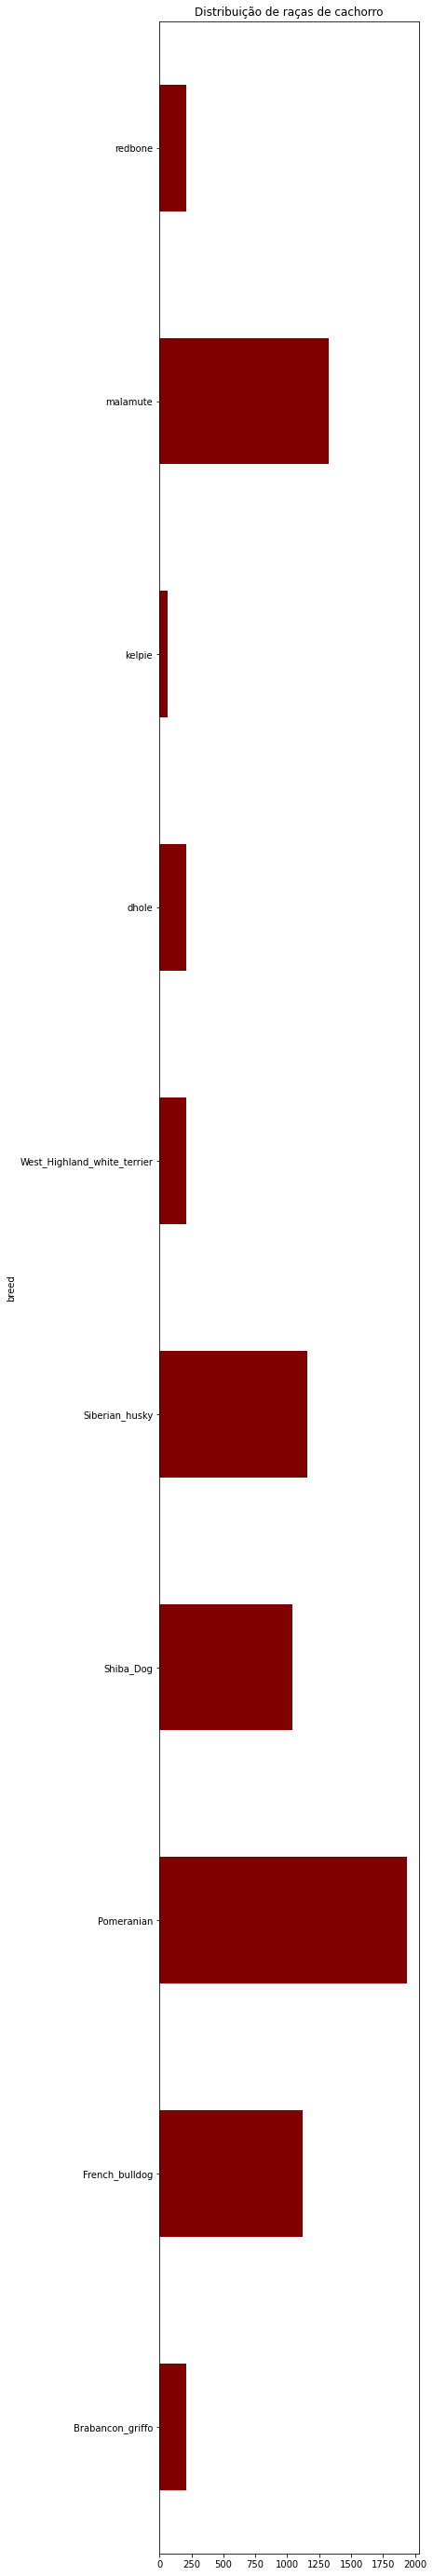

In [6]:
ax = distribuition_images.plot(x="Breed", y="Count", kind="barh",figsize=(5, 50))
distribuition_images.plot(x="breed", y="count", kind="barh", ax=ax, color="maroon")
ax.set_title('Distribuição de raças de cachorro')


### Visualizando imagens

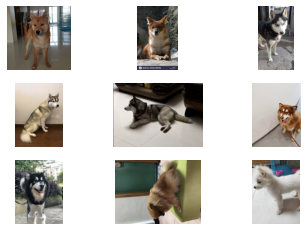

In [7]:
df = df_images.sample(n=9)
count = 0

for index, row in df.iterrows():
    image = Image.open(row["path_file"])

    # Exibir a imagem
    plt.subplot(3, 3, count + 1)
    plt.imshow(image)
    plt.axis('off')
    count += 1


In [8]:
df

,breed,filename,path_file
599,Shiba_Dog,n100601.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
7211,dhole,n113497.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
3272,Siberian_husky,n103284.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
2500,Siberian_husky,n102505.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
3163,Siberian_husky,n103175.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
4521,malamute,n104541.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
3632,malamute,n103647.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
5892,Pomeranian,n105917.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
5206,Pomeranian,n105230.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...


### Pré-processamento de imagens

#### Funções auxiliares para armazenar array de imagens em lotes

In [9]:
if platform == "linux" or platform == "linux2":
    os_path = "/" 
elif platform == "win32":
   os_path = "\\"

folder_path = os.getcwd() + os_path + "low-resolution"
slot_size = 70

#Retorna uma tupla com os path de cada imagem e o target randomizados
def load_path_of_dataset():
    arquivos = os.listdir(folder_path)
    subpastas = [subpasta for subpasta in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subpasta))]
    imagens_path = []
    labels = []
    for subpasta in subpastas:
        subpasta_path = os.path.join(folder_path, subpasta)
        imagens = os.listdir(subpasta_path)
        imagens_path.extend([subpasta + os_path + s for s in imagens])
        label = subpasta.split("-")[2]
        labels.extend([label for s in imagens])
    # minha_lista = list(zip(imagens_path, labels))
    # random.shuffle(minha_lista)
    return imagens_path, labels

#função responsavel em realizar a divisão em slots
#recebe como parametro a tupla da função load_path_of_dataset, e o numero da interação para carregar o dataframe
#retorna uma tupla menor, e o numero máximo de interações posiveis até o fim do dataset
def slot_loading(interacao, imagens_amostradas, imagens_labels):
    if interacao <= 0:
        raise ValueError('O valor da interação, deve ser maior que zero ! ')
    elif interacao > (interacao * len(imagens_amostradas)):
        raise ValueError('O valor da interação, é muito grande !')
    
    start_index = (interacao - 1) * slot_size
    end_index = interacao * slot_size
    if end_index > len(imagens_amostradas):
        return imagens_amostradas[start_index:], imagens_labels[start_index:]
    
    return imagens_amostradas[start_index:end_index], tf.convert_to_tensor(imagens_labels[start_index:end_index]), len(imagens_amostradas) // slot_size

#Recebe como parametro uma tupla
#retorna um dataset já pré-processado e formatados
def get_images(imagens_amostradas):
    img_size_height = 300
    img_size_width = 400
    images = []
    for imagem_nome in imagens_amostradas:
        try:
            imagem_path = os.path.join(folder_path, imagem_nome)
            imagem = Image.open(imagem_path)
            imagem = imagem.resize((img_size_width, img_size_height))  # Redimensiona para um tamanho comum
            imagem_array = np.array(imagem) / 255.0  # Normaliza dividindo por 255
            images.append(imagem_array)
        except Exception as error:
            print("ocorreu um erro com imagem_path: ", imagem_path, " imagem_nome " + imagem_nome," imagem_nome[0] " + imagem_nome[0], " imagens_amostradas: " , imagens_amostradas)
    images = tf.stack(images)
    return images


## Separação do Conjunto de teste e treino

In [10]:
# Sua tupla
X, y = load_path_of_dataset()

# #label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)
# y = y.tolist()
# # Codifique os rótulos como vetores one-hot
# y = tf.one_hot(y, depth=10)
# # Converta o tensor para um array numpy
# y = y.numpy()


y_unique = np.unique(y)

index_value = {value: idx for idx, value in enumerate(y_unique)}
count_values_uniques = len(y_unique)
matrix_one_hot = np.zeros((len(y), count_values_uniques), dtype=bool)

for i, string in enumerate(y):
    index = index_value[string]
    matrix_one_hot[i, index] = True


y = matrix_one_hot

# Separando 70% para treino e 30% para teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

# Exibindo as dimensões dos conjuntos de treino e teste
print("Dimensões do conjunto de treino:", len(X_treino), len(y_treino))
print("Dimensões do conjunto de teste:", len(X_teste), len(y_teste))

Dimensões do conjunto de treino: 5235 5235
Dimensões do conjunto de teste: 2244 2244


## Criação do modelo

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
# Model Architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(300,400,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10,activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 400, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 200, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 100, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 100, 64)       8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 50, 64)       0

### Treinamento em batch 

In [12]:
# Treinar o modelo
x_new, y_new, i = slot_loading(1, X_treino, y_treino)
x_new_tensor = get_images(x_new)

model.fit(x_new_tensor, y_new, batch_size=10, epochs=12)
for o in range(1, i):
    print( o," of " ,i)
    x_new, y_new = None, None
    x_new, y_new, i = slot_loading(o, X_treino, y_treino)
    x_new = get_images(x_new)
    model.fit(x_new , y_new, batch_size=10, epochs=12)

Epoch 1/12
7/7 [==============================] - 5s 581ms/step - loss: 0.6405 - accuracy: 0.2000
Epoch 2/12
7/7 [==============================] - 4s 604ms/step - loss: 0.3627 - accuracy: 0.2429
Epoch 3/12
7/7 [==============================] - 4s 577ms/step - loss: 0.3106 - accuracy: 0.2429
Epoch 4/12
7/7 [==============================] - 4s 560ms/step - loss: 0.3038 - accuracy: 0.2286
Epoch 5/12
7/7 [==============================] - 4s 545ms/step - loss: 0.3010 - accuracy: 0.3429
Epoch 6/12
7/7 [==============================] - 4s 621ms/step - loss: 0.2925 - accuracy: 0.3143
Epoch 7/12
7/7 [==============================] - 4s 542ms/step - loss: 0.2903 - accuracy: 0.2714
Epoch 8/12
7/7 [==============================] - 4s 643ms/step - loss: 0.2795 - accuracy: 0.3286
Epoch 9/12
7/7 [==============================] - 4s 594ms/step - loss: 0.2598 - accuracy: 0.3429
Epoch 10/12
7/7 [==============================] - 4s 592ms/step - loss: 0.2547 - accuracy: 0.3857
Epoch 11/12
7/7 [==

7/7 [==============================] - 5s 731ms/step - loss: 0.0269 - accuracy: 0.9714
Epoch 12/12
7/7 [==============================] - 4s 608ms/step - loss: 0.0242 - accuracy: 0.9857
7  of  74
Epoch 1/12
7/7 [==============================] - 4s 647ms/step - loss: 0.4169 - accuracy: 0.4000
Epoch 2/12
7/7 [==============================] - 5s 796ms/step - loss: 0.2384 - accuracy: 0.5286
Epoch 3/12
7/7 [==============================] - 4s 570ms/step - loss: 0.1949 - accuracy: 0.7000
Epoch 4/12
7/7 [==============================] - 4s 577ms/step - loss: 0.1582 - accuracy: 0.7000
Epoch 5/12
7/7 [==============================] - 4s 517ms/step - loss: 0.1067 - accuracy: 0.8429
Epoch 6/12
7/7 [==============================] - 4s 543ms/step - loss: 0.0711 - accuracy: 0.9429
Epoch 7/12
7/7 [==============================] - 4s 620ms/step - loss: 0.0425 - accuracy: 0.9714
Epoch 8/12
7/7 [==============================] - 4s 633ms/step - loss: 0.0371 - accuracy: 0.9714
Epoch 9/12
7/7 [====

7/7 [==============================] - 4s 529ms/step - loss: 0.0353 - accuracy: 0.9571
Epoch 10/12
7/7 [==============================] - 4s 521ms/step - loss: 0.0265 - accuracy: 0.9857
Epoch 11/12
7/7 [==============================] - 4s 522ms/step - loss: 0.0148 - accuracy: 0.9857
Epoch 12/12
7/7 [==============================] - 4s 501ms/step - loss: 0.0228 - accuracy: 0.9714
14  of  74
Epoch 1/12
7/7 [==============================] - 4s 586ms/step - loss: 0.5170 - accuracy: 0.2286
Epoch 2/12
7/7 [==============================] - 4s 579ms/step - loss: 0.2689 - accuracy: 0.3714
Epoch 3/12
7/7 [==============================] - 4s 584ms/step - loss: 0.2208 - accuracy: 0.5571
Epoch 4/12
7/7 [==============================] - 4s 578ms/step - loss: 0.1609 - accuracy: 0.7143
Epoch 5/12
7/7 [==============================] - 4s 572ms/step - loss: 0.1180 - accuracy: 0.8286
Epoch 6/12
7/7 [==============================] - 4s 598ms/step - loss: 0.0930 - accuracy: 0.8714
Epoch 7/12
7/7 [=

7/7 [==============================] - 4s 596ms/step - loss: 0.0678 - accuracy: 0.8857
Epoch 8/12
7/7 [==============================] - 5s 679ms/step - loss: 0.0507 - accuracy: 0.9429
Epoch 9/12
7/7 [==============================] - 5s 759ms/step - loss: 0.0317 - accuracy: 0.9714
Epoch 10/12
7/7 [==============================] - 5s 806ms/step - loss: 0.0325 - accuracy: 0.9429
Epoch 11/12
7/7 [==============================] - 5s 712ms/step - loss: 0.0278 - accuracy: 0.9857
Epoch 12/12
7/7 [==============================] - 5s 643ms/step - loss: 0.0239 - accuracy: 0.9857
21  of  74
Epoch 1/12
7/7 [==============================] - 5s 694ms/step - loss: 0.4869 - accuracy: 0.2429
Epoch 2/12
7/7 [==============================] - 4s 551ms/step - loss: 0.2421 - accuracy: 0.4714
Epoch 3/12
7/7 [==============================] - 4s 531ms/step - loss: 0.1785 - accuracy: 0.6286
Epoch 4/12
7/7 [==============================] - 4s 525ms/step - loss: 0.1473 - accuracy: 0.7143
Epoch 5/12
7/7 [=

7/7 [==============================] - 4s 606ms/step - loss: 0.1569 - accuracy: 0.7000
Epoch 6/12
7/7 [==============================] - 4s 607ms/step - loss: 0.1371 - accuracy: 0.7857
Epoch 7/12
7/7 [==============================] - 4s 620ms/step - loss: 0.1095 - accuracy: 0.8000
Epoch 8/12
7/7 [==============================] - 4s 633ms/step - loss: 0.0947 - accuracy: 0.8000
Epoch 9/12
7/7 [==============================] - 5s 721ms/step - loss: 0.0690 - accuracy: 0.8714
Epoch 10/12
7/7 [==============================] - 5s 743ms/step - loss: 0.0723 - accuracy: 0.9000
Epoch 11/12
7/7 [==============================] - 5s 711ms/step - loss: 0.0613 - accuracy: 0.9143
Epoch 12/12
7/7 [==============================] - 4s 581ms/step - loss: 0.0556 - accuracy: 0.9143
28  of  74
Epoch 1/12
7/7 [==============================] - 4s 614ms/step - loss: 0.3873 - accuracy: 0.2429
Epoch 2/12
7/7 [==============================] - 4s 537ms/step - loss: 0.3149 - accuracy: 0.2857
Epoch 3/12
7/7 [=

7/7 [==============================] - 4s 498ms/step - loss: 0.2258 - accuracy: 0.5286
Epoch 4/12
7/7 [==============================] - 4s 512ms/step - loss: 0.1361 - accuracy: 0.7143
Epoch 5/12
7/7 [==============================] - 4s 503ms/step - loss: 0.1394 - accuracy: 0.7429
Epoch 6/12
7/7 [==============================] - 4s 529ms/step - loss: 0.1170 - accuracy: 0.8000
Epoch 7/12
7/7 [==============================] - 4s 633ms/step - loss: 0.0980 - accuracy: 0.8571
Epoch 8/12
7/7 [==============================] - 4s 638ms/step - loss: 0.1032 - accuracy: 0.8143
Epoch 9/12
7/7 [==============================] - 4s 608ms/step - loss: 0.0756 - accuracy: 0.8714
Epoch 10/12
7/7 [==============================] - 5s 653ms/step - loss: 0.0658 - accuracy: 0.9000
Epoch 11/12
7/7 [==============================] - 4s 565ms/step - loss: 0.0544 - accuracy: 0.9286
Epoch 12/12
7/7 [==============================] - 4s 544ms/step - loss: 0.0495 - accuracy: 0.9000
35  of  74
Epoch 1/12
7/7 [=

7/7 [==============================] - 4s 609ms/step - loss: 0.4532 - accuracy: 0.2714
Epoch 2/12
7/7 [==============================] - 4s 525ms/step - loss: 0.2543 - accuracy: 0.4286
Epoch 3/12
7/7 [==============================] - 4s 546ms/step - loss: 0.2086 - accuracy: 0.5429
Epoch 4/12
7/7 [==============================] - 3s 498ms/step - loss: 0.1932 - accuracy: 0.6571
Epoch 5/12
7/7 [==============================] - 4s 502ms/step - loss: 0.1554 - accuracy: 0.7143
Epoch 6/12
7/7 [==============================] - 3s 496ms/step - loss: 0.1563 - accuracy: 0.7286
Epoch 7/12
7/7 [==============================] - 3s 491ms/step - loss: 0.1340 - accuracy: 0.7286
Epoch 8/12
7/7 [==============================] - 4s 509ms/step - loss: 0.1134 - accuracy: 0.8286
Epoch 9/12
7/7 [==============================] - 3s 499ms/step - loss: 0.1030 - accuracy: 0.8286
Epoch 10/12
7/7 [==============================] - 3s 488ms/step - loss: 0.0999 - accuracy: 0.8000
Epoch 11/12
7/7 [=============

7/7 [==============================] - 4s 543ms/step - loss: 0.0695 - accuracy: 0.8571
Epoch 12/12
7/7 [==============================] - 3s 497ms/step - loss: 0.0594 - accuracy: 0.9000
48  of  74
Epoch 1/12
7/7 [==============================] - 4s 599ms/step - loss: 0.4200 - accuracy: 0.3714
Epoch 2/12
7/7 [==============================] - 4s 571ms/step - loss: 0.2405 - accuracy: 0.4429
Epoch 3/12
7/7 [==============================] - 4s 604ms/step - loss: 0.2154 - accuracy: 0.6000
Epoch 4/12
7/7 [==============================] - 4s 522ms/step - loss: 0.1674 - accuracy: 0.6429
Epoch 5/12
7/7 [==============================] - 4s 552ms/step - loss: 0.1535 - accuracy: 0.7286
Epoch 6/12
7/7 [==============================] - 4s 529ms/step - loss: 0.1356 - accuracy: 0.7286
Epoch 7/12
7/7 [==============================] - 4s 507ms/step - loss: 0.1183 - accuracy: 0.7714
Epoch 8/12
7/7 [==============================] - 3s 494ms/step - loss: 0.1086 - accuracy: 0.7857
Epoch 9/12
7/7 [===

7/7 [==============================] - 4s 546ms/step - loss: 0.0976 - accuracy: 0.8000
Epoch 10/12
7/7 [==============================] - 4s 562ms/step - loss: 0.1027 - accuracy: 0.7857
Epoch 11/12
7/7 [==============================] - 3s 488ms/step - loss: 0.0810 - accuracy: 0.8571
Epoch 12/12
7/7 [==============================] - 4s 497ms/step - loss: 0.0662 - accuracy: 0.9143
55  of  74
Epoch 1/12
7/7 [==============================] - 4s 563ms/step - loss: 0.3722 - accuracy: 0.3286
Epoch 2/12
7/7 [==============================] - 4s 578ms/step - loss: 0.2580 - accuracy: 0.4857
Epoch 3/12
7/7 [==============================] - 4s 576ms/step - loss: 0.1854 - accuracy: 0.7000
Epoch 4/12
7/7 [==============================] - 4s 554ms/step - loss: 0.1875 - accuracy: 0.6000
Epoch 5/12
7/7 [==============================] - 4s 558ms/step - loss: 0.1516 - accuracy: 0.6571
Epoch 6/12
7/7 [==============================] - 4s 578ms/step - loss: 0.1206 - accuracy: 0.7429
Epoch 7/12
7/7 [=

7/7 [==============================] - 4s 526ms/step - loss: 0.1273 - accuracy: 0.7000
Epoch 8/12
7/7 [==============================] - 4s 531ms/step - loss: 0.0906 - accuracy: 0.8143
Epoch 9/12
7/7 [==============================] - 4s 506ms/step - loss: 0.0870 - accuracy: 0.8000
Epoch 10/12
7/7 [==============================] - 4s 534ms/step - loss: 0.0682 - accuracy: 0.8714
Epoch 11/12
7/7 [==============================] - 4s 530ms/step - loss: 0.0882 - accuracy: 0.8286
Epoch 12/12
7/7 [==============================] - 4s 508ms/step - loss: 0.0772 - accuracy: 0.8429
62  of  74
Epoch 1/12
7/7 [==============================] - 4s 561ms/step - loss: 0.3611 - accuracy: 0.2429
Epoch 2/12
7/7 [==============================] - 4s 591ms/step - loss: 0.2371 - accuracy: 0.4286
Epoch 3/12
7/7 [==============================] - 4s 613ms/step - loss: 0.1993 - accuracy: 0.5857
Epoch 4/12
7/7 [==============================] - 4s 558ms/step - loss: 0.1812 - accuracy: 0.5857
Epoch 5/12
7/7 [=

7/7 [==============================] - 4s 513ms/step - loss: 0.1426 - accuracy: 0.7143
Epoch 6/12
7/7 [==============================] - 4s 511ms/step - loss: 0.1363 - accuracy: 0.7714
Epoch 7/12
7/7 [==============================] - 4s 520ms/step - loss: 0.1101 - accuracy: 0.7857
Epoch 8/12
7/7 [==============================] - 4s 500ms/step - loss: 0.1042 - accuracy: 0.7714
Epoch 9/12
7/7 [==============================] - 3s 484ms/step - loss: 0.0875 - accuracy: 0.8571
Epoch 10/12
7/7 [==============================] - 3s 500ms/step - loss: 0.0964 - accuracy: 0.7857
Epoch 11/12
7/7 [==============================] - 3s 497ms/step - loss: 0.0872 - accuracy: 0.8571
Epoch 12/12
7/7 [==============================] - 3s 477ms/step - loss: 0.0839 - accuracy: 0.8000
69  of  74
Epoch 1/12
7/7 [==============================] - 3s 493ms/step - loss: 0.4636 - accuracy: 0.2143
Epoch 2/12
7/7 [==============================] - 3s 489ms/step - loss: 0.3427 - accuracy: 0.2857
Epoch 3/12
7/7 [=

### Salvando modelo

In [15]:
folder_path = os.getcwd() + os_path + "modelo_salvo"
model.save(folder_path+ os_path + "modelo_salvo.h5")


### Avaliação do modelo

In [14]:
x_new, y_new, i = slot_loading(1, X_teste, y_teste)
x_new_tensor = get_images(x_new)
test_loss, test_accuracy = 0, 0
num_batches = 0

test_loss, test_accuracy = model.evaluate(x_new_tensor, y_new)
print( 0," of " ,i)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))
for o in range(1, i):
    print( o," of " ,i)
    x_new, y_new = None, None
    x_new, y_new, i = slot_loading(o,X_teste, y_teste)
    x_new = get_images(x_new)
    batch_loss, batch_accuracy  = model.evaluate(x_new , y_new)
    test_loss += batch_loss
    test_accuracy += batch_accuracy
    num_batches += 1
    print('Test loss: {}'.format(test_loss))
    print('Test accuracy: {}'.format(test_accuracy))
    
test_loss /= num_batches
test_accuracy /= num_batches

print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

3/3 [==============================] - 3s 400ms/step - loss: 0.4001 - accuracy: 0.3286
0  of  32
Test loss: 0.40012407302856445
Test accuracy: 0.3285714387893677
1  of  32
3/3 [==============================] - 1s 350ms/step - loss: 0.4001 - accuracy: 0.3286
Test loss: 0.8002481460571289
Test accuracy: 0.6571428775787354
2  of  32
3/3 [==============================] - 2s 444ms/step - loss: 0.3422 - accuracy: 0.3143
Test loss: 1.142408311367035
Test accuracy: 0.9714286029338837
3  of  32
3/3 [==============================] - 1s 351ms/step - loss: 0.3053 - accuracy: 0.3286
Test loss: 1.4477217197418213
Test accuracy: 1.3000000417232513
4  of  32
3/3 [==============================] - 1s 285ms/step - loss: 0.3288 - accuracy: 0.3714
Test loss: 1.7765334248542786
Test accuracy: 1.671428620815277
5  of  32
3/3 [==============================] - 1s 287ms/step - loss: 0.3399 - accuracy: 0.3571
Test loss: 2.1164832711219788
Test accuracy: 2.0285714864730835
6  of  32
3/3 [====================